**Méthodologie** :
- Utilisation de **pipelines Scikit-learn** pour intégrer standardisation + entraînement.
- Évaluation sur l’ensemble de test avec trois métriques :
  - **RMSE** (Root Mean Squared Error)
  - **MAE** (Mean Absolute Error)
  - **R²** (Coefficient de détermination)

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

df = pd.read_csv("../data/assurance_maladie.csv")

df.drop_duplicates(inplace=True)

X = df.drop("charges", axis=1)
y = np.log1p(df["charges"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_features = ["age", "bmi", "children"]
cat_features = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   
    ("scaler", StandardScaler())                     
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  
    ("encoder", OneHotEncoder(handle_unknown="ignore"))    
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

results = []
models=[LinearRegression, RandomForestRegressor, XGBRegressor, SVR]

for model in models:
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "modèle":model.__name__,
        "RMSE" :rmse,
        "MAE"  :mae,
        "R²"   :r2,
        "Score Train": pipeline.score(X_train, y_train),
        "Score Test": pipeline.score(X_test, y_test)
    })

results_modeles=pd.DataFrame(results)
print(results_modeles)

results_modeles.to_csv("../data/results_modeles.csv",index=False)



                  modèle      RMSE       MAE        R²  Score Train  \
0       LinearRegression  0.397775  0.260656  0.829479     0.749653   
1  RandomForestRegressor  0.363950  0.189686  0.857246     0.971381   
2           XGBRegressor  0.430495  0.224453  0.800271     0.995320   
3                    SVR  0.325784  0.161277  0.885616     0.829906   

   Score Test  
0    0.829479  
1    0.857246  
2    0.800271  
3    0.885616  


####  Feature Story 3 : Tuning des Hyperparamètres


1. **Sélection des modèles**  
   - Basée sur les performances initiales (avec paramètres par défaut).  
   - **RandomForestRegressor  ** et **SVR  ** retenus pour leur R² élevé (> 0.85) et faible erreur.

**Définition des grilles de recherche**  
   - Utilisation de `RandomizedSearchCV` avec **validation croisée à 5 folds** pour un bon compromis entre efficacité et exploration.  
   - Grilles définies comme suit :

     **Pour Random Forest** :

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

param_grid_rf = {
    "model__n_estimators": [400, 500, 600],
    "model__max_depth": [None, 3, 4, 5, 6],
    "model__min_samples_split": [5, 6, 7]
}

grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF CV score:", grid_rf.best_score_)
best_rf_model = grid_rf.best_estimator_


Best RF params: {'model__max_depth': 5, 'model__min_samples_split': 6, 'model__n_estimators': 600}
Best RF CV score: 0.8141036846679466


     **Pour XGBoost** :


In [7]:
xgb_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42))
])

param_grid_xgb = {
    "model__n_estimators": [400, 500, 600],
    "model__max_depth": [2, 3, 5],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.6, 0.7, 0.8, 0.9]
}

grid_xgb = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV score:", grid_xgb.best_score_)
best_xgb_model = grid_xgb.best_estimator_


Best XGB params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.8}
Best XGB CV score: 0.8211994488221368


     **Pour SVR** :


In [8]:
svr_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVR())
])

param_grid_svr = {
    "model__C": [0.1, 1, 10],
    "model__epsilon": [0.01, 0.1, 0.5],
    "model__kernel": ["linear", "rbf"],
    "model__gamma": ["scale", "auto"]
}

grid_svr = GridSearchCV(
    estimator=svr_pipe,
    param_grid=param_grid_svr,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_svr.fit(X_train, y_train)
print("Best SVR params:", grid_svr.best_params_)
print("Best SVR CV score:", grid_svr.best_score_)
best_svr_model = grid_svr.best_estimator_


Best SVR params: {'model__C': 10, 'model__epsilon': 0.1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best SVR CV score: 0.8182029157856829


In [ ]:
results_modeles = pd.read_csv("../data/results_modeles.csv")

results = []

def eval_modele(model, X_train, y_train, X_test, y_test, nom_modele):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "modèle": nom_modele,  
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2,
        "Score Train": model.score(X_train, y_train),
        "Score Test": model.score(X_test, y_test)
    })

eval_modele(best_rf_model, X_train, y_train, X_test, y_test, "Random Forest (Tuning)")
eval_modele(best_xgb_model, X_train, y_train, X_test, y_test, "XGBoost (Tuning)")
eval_modele(best_svr_model, X_train, y_train, X_test, y_test, "SVR (Tuning)")

results_modeles_apres_tuning = pd.DataFrame(results)

comparaison_modeles = pd.concat([results_modeles, results_modeles_apres_tuning], ignore_index=True)

comparaison_modeles.to_csv("../data/comparaison_modeles.csv", index=False)

print(comparaison_modeles)


                   modèle      RMSE       MAE        R²  Score Train  \
0        LinearRegression  0.397775  0.260656  0.829479     0.749653   
1   RandomForestRegressor  0.380709  0.199414  0.843796     0.973273   
2            XGBRegressor  0.430495  0.224453  0.800271     0.995320   
3                     SVR  0.325784  0.161277  0.885616     0.829906   
4  Random Forest (Tuning)  0.331241  0.177851  0.881752     0.849996   
5        XGBoost (Tuning)  0.324277  0.181344  0.886672     0.851800   
6            SVR (Tuning)  0.318231  0.158259  0.890858     0.832819   

   Score Test  
0    0.829479  
1    0.843796  
2    0.800271  
3    0.885616  
4    0.881752  
5    0.886672  
6    0.890858  


**Comparer les performances des modèles avant et après optimisation (RMSE, MAE, R²).**

                   modèle      RMSE       MAE        R²  Score Train  \
0        LinearRegression  0.397775  0.260656  0.829479     0.749653   
1   RandomForestRegressor  0.380709  0.199414  0.843796     0.973273   
2            XGBRegressor  0.430495  0.224453  0.800271     0.995320   
3                     SVR  0.325784  0.161277  0.885616     0.829906   
4  Random Forest (Tuning)  0.331241  0.177851  0.881752     0.849996   
5        XGBoost (Tuning)  0.324277  0.181344  0.886672     0.851800   
6            SVR (Tuning)  0.318231  0.158259  0.890858     0.832819   

   Score Test  
0    0.829479  
1    0.843796  
2    0.800271  
3    0.885616  
4    0.881752  
5    0.886672  
6    0.890858  


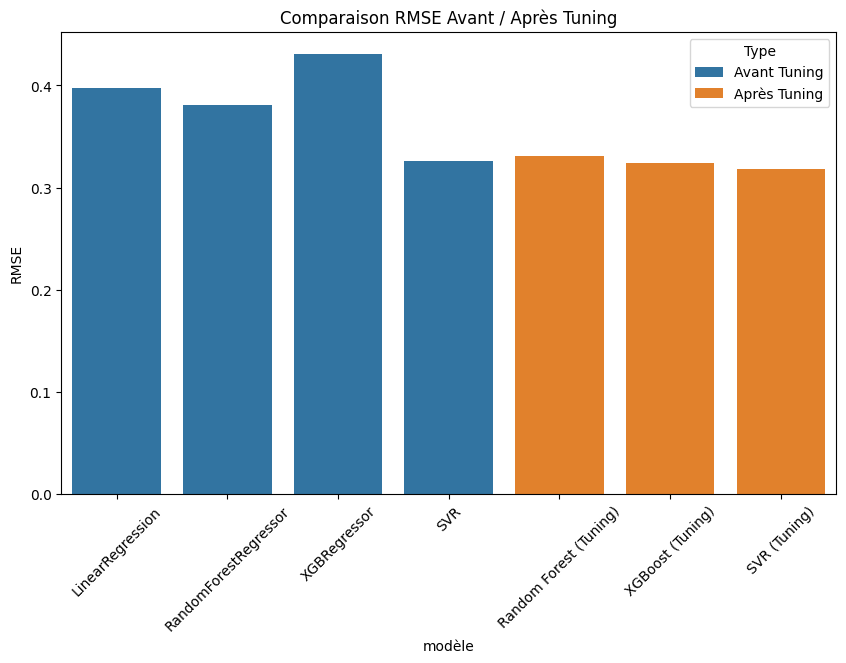

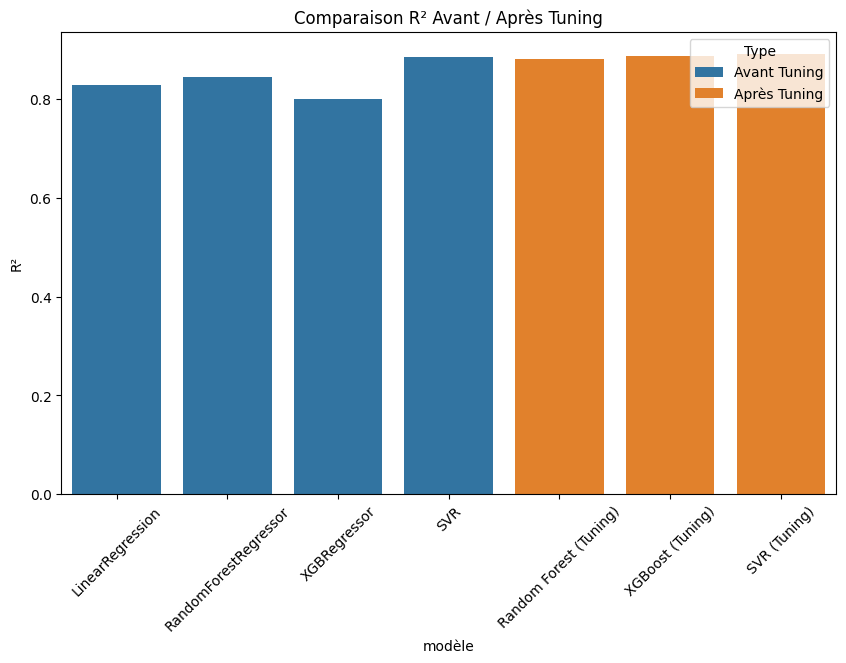

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
dataframe=pd.read_csv("../data/comparaison_modeles.csv")
print(dataframe.head(10))
dataframe['Type'] = ['Avant Tuning', 'Avant Tuning', 'Avant Tuning', 'Avant Tuning', 'Après Tuning','Après Tuning','Après Tuning']

plt.figure(figsize=(10,6))
sns.barplot(data=dataframe, x='modèle', y='RMSE', hue='Type')
plt.xticks(rotation=45)
plt.title("Comparaison RMSE Avant / Après Tuning")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=dataframe, x='modèle', y='R²', hue='Type')
plt.xticks(rotation=45)
plt.title("Comparaison R² Avant / Après Tuning")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_model(model, X_test, y_test, nom_modele):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    residus = y_test - y_pred
    df_eval = pd.DataFrame({
        "Réel": y_test,
        "Prédit": y_pred,
        "Résidu": residus
    })
    
    return rmse, mae, r2, df_eval


In [ ]:
modeles = {
    "Random Forest": best_rf_model,
    "XGBoost": best_xgb_model,
    "SVR": best_svr_model
}

resultats = []

eval_dfs = {}  
for nom, modele in modeles.items():
    rmse, mae, r2, df_eval = eval_model(modele, X_test, y_test, nom)
    resultats.append({
        "Modèle": nom,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })
    eval_dfs[nom] = df_eval

df_resultats = pd.DataFrame(resultats)
print(df_resultats)


          Modèle      RMSE       MAE        R²
0  Random Forest  0.331241  0.177851  0.881752
1        XGBoost  0.324277  0.181344  0.886672
2            SVR  0.318231  0.158259  0.890858


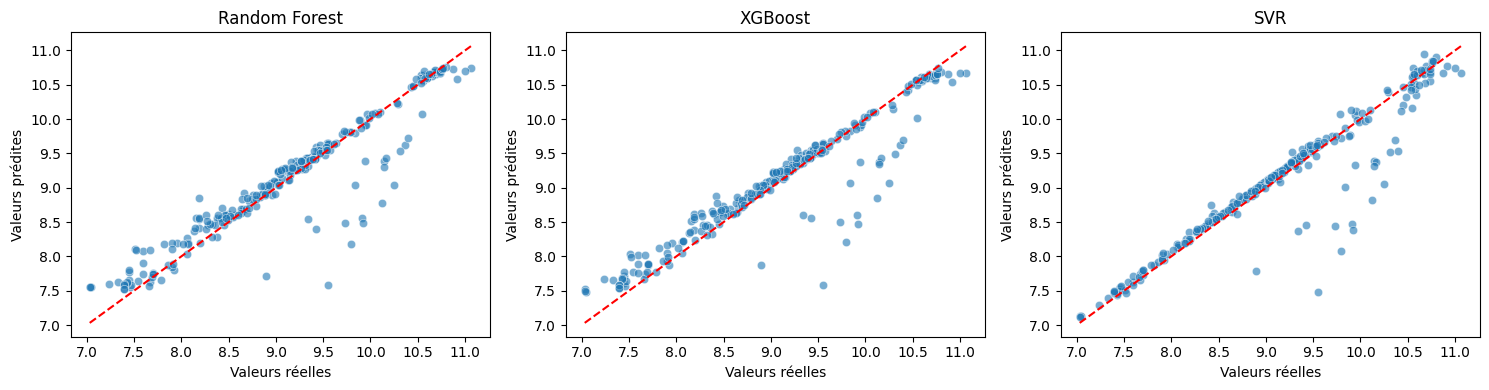

In [13]:
plt.figure(figsize=(15,4))
for i, (nom, df_eval) in enumerate(eval_dfs.items(), 1):
    plt.subplot(1, len(modeles), i)
    sns.scatterplot(x="Réel", y="Prédit", data=df_eval, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ligne y=x
    plt.title(nom)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
plt.tight_layout()
plt.show()


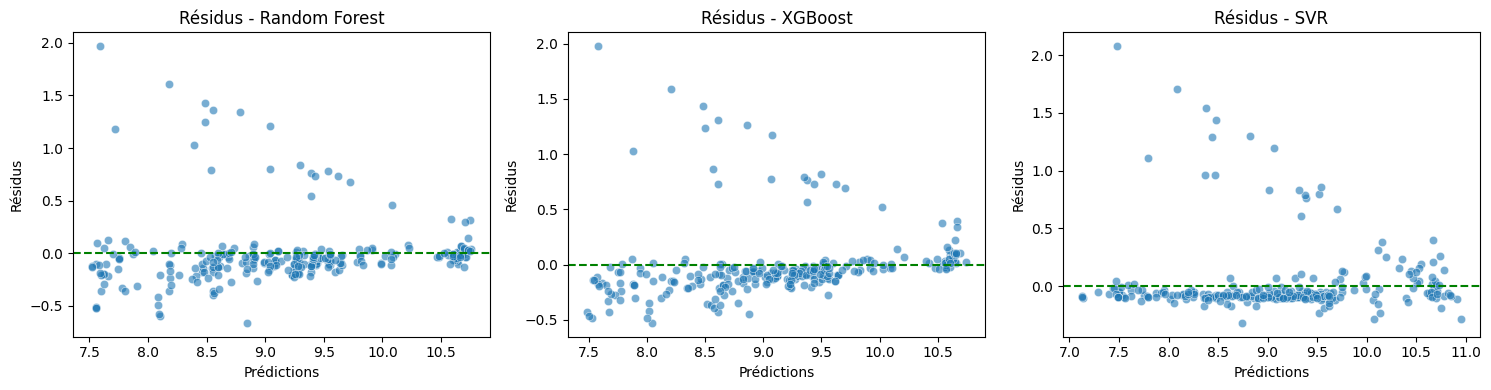

In [14]:
plt.figure(figsize=(15,4))
for i, (nom, df_eval) in enumerate(eval_dfs.items(), 1):
    plt.subplot(1, len(modeles), i)
    sns.scatterplot(x="Prédit", y="Résidu", data=df_eval, alpha=0.6)
    plt.axhline(0, color='g', linestyle='--')
    plt.title(f"Résidus - {nom}")
    plt.xlabel("Prédictions")
    plt.ylabel("Résidus")
plt.tight_layout()
plt.show()


In [15]:

meilleur_modele = df_resultats.loc[df_resultats["RMSE"].idxmin()]
print("Meilleur modèle :", meilleur_modele["Modèle"])


Meilleur modèle : SVR


**Tous les modèles sont performants.**

-SVR est légèrement meilleur numériquement,

-Mais XGBoost reste plus stable et plus robuste visuellement (résidus bien répartis).

 **En pratique :**

-Si tu veux le modèle le plus précis → SVR

-Si tu veux le modèle le plus robuste et généralisable → XGBoost

In [16]:
import joblib

joblib.dump(best_rf_model, "../models/modele_final.pkl")

print("Modèle sauvegardé avec succès !")


Modèle sauvegardé avec succès !


In [ ]:
modele_charge = joblib.load("../data/modele_final.pkl")

nouvelle_donnee = {
    "age": 30,
    "sex": "male",
    "bmi": 28.5,
    "children": 2,
    "smoker": "no",
    "region": "northwest"
}

import pandas as pd

df_nouvelle = pd.DataFrame([nouvelle_donnee])

pred_log = modele_charge.predict(df_nouvelle)
pred = np.expm1(pred_log)  

print(f"Prédiction des charges d'assurance : {pred[0]:.2f}")


Prédiction des charges d'assurance : 5561.68
